# Predecir sobre eval.json

## Librerías

In [1]:
import os
import json
import pandas as pd
import random
import csv

import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import shared_functions as custom_sharfun  #el archivo .py con funciones compartidas

from peft import PeftModel
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from transformers import logging as hf_logging
hf_logging.set_verbosity_warning()

In [2]:
# IMPORTANTE: dejar las mismas configuraciones que train.ipynb
# ------------------------------------------------------------------

# Data / tokenization
MAX_LENGTH = 2048

# Evaluación
GEN_MAX_NEW_TOKENS = 512

# Configuración del dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
GLB_SEED = 42
torch.manual_seed(GLB_SEED)
random.seed(GLB_SEED)
np.random.seed(GLB_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(GLB_SEED)

Using device: cuda


In [3]:
MODEL_NAME = "Qwen/Qwen3-0.6B-Base"
OUTPUT_DIR = "output/results/v01"
ADAPTER_DIR = os.path.join(OUTPUT_DIR, "modfinal")

# cargar tokenizer
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR, trust_remote_code=True)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# cargar modelo base
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)

# cargar adaptadores LORA
model = PeftModel.from_pretrained(base_model, ADAPTER_DIR)

model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen3ForCausalLM(
      (model): Qwen3Model(
        (embed_tokens): Embedding(151936, 1024)
        (layers): ModuleList(
          (0-27): 28 x Qwen3DecoderLayer(
            (self_attn): Qwen3Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1024, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [4]:
DATA_PATH = "data/eval/eval.json" 
with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

raw_data[:2]  # Mostrar los primeros 2 ejemplos

[{'id': 0,
  'natural_language': '¡Hola!👋 \n\nEspero que estés bien. Quería hacer un pedido, algo parecido a lo que cogí la última vez. Me gustaría pedir unas 4 botellitas de ese whisky Chivas Regal de 12 años, el de mil mililitros, creo que era. Ah, y no olvides el queso ese griego de San Martín para untar, que con eso siempre se acierta. Además, estoy pensando en unos 9 yogures de vainilla francesa de la marca Gloria. \n\nSi puedes, sería genial que me los mandes rapidito, pero no me lo envies este finde, que tengo planes, ya sabes 😅. Y sí, pago en euritos, aunque no estoy seguro de si eso es algo que influya. Te mando mi número por si necesitas contactarme, es el 608-899-4091 extensión 860. Si es más fácil, también puedes escribirme al email, jacob.vasquez494@gmail.com, pero prefiero que me llames. \n\nAh, y por cierto, ayer llovió un montón aquí. Espero que tu clima esté mejor. Bueno, eso es todo, házmelo saber cuando puedas. ¡Gracias! 🙏'},
 {'id': 1,
  'natural_language': 'Asunto:

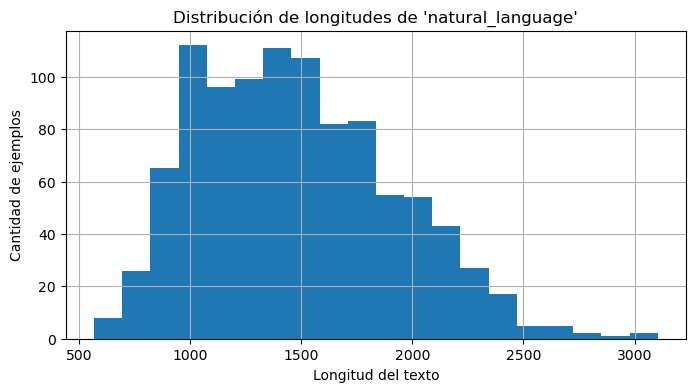

In [5]:
# Obtener longitudes - histograma
longitudes = [len(item["natural_language"]) for item in raw_data]
plt.figure(figsize=(8, 4))
plt.hist(longitudes, bins=20)  # puedes ajustar el número de bins
plt.title("Distribución de longitudes de 'natural_language'")
plt.xlabel("Longitud del texto")
plt.ylabel("Cantidad de ejemplos")
plt.grid(True)
plt.show()

In [6]:
# Cargar directamente un archivo JSON
from datasets import load_dataset
val_list = load_dataset('json', data_files=DATA_PATH)['train']
print(type(val_list))  # Será datasets.Dataset

Generating train split: 0 examples [00:00, ? examples/s]

<class 'datasets.arrow_dataset.Dataset'>


In [7]:
print(len(val_list))

1000


In [8]:
results_submission = []

for idx, ex in enumerate(tqdm(val_list, desc="Eval")):  # iterar sobre todos los ejemplos
    text = ex["natural_language"]
    id_save = ex["id"]
    raw = custom_sharfun.generate_json_raw(
        text=text,
        max_new_tokens=GEN_MAX_NEW_TOKENS,
        max_length=MAX_LENGTH,
        tokenizer=tokenizer,
        model=model,
        device=DEVICE
    )
    pred_obj = custom_sharfun.extract_json_from_text(raw)

    # Fallback seguro
    if pred_obj is None:
        pred_obj = {}

    results_submission.append({
        "id": id_save,
        "prediction": pred_obj
    })

Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
results_submission[0:2]  # Mostrar los primeros 2 resultados de la predicción

[{'id': 0,
  'prediction': {'buyer': {'addresses': None,
    'contact': {'alt_email': 'jacob.vasquez494@gmail.com',
     'phone': '608-899-4091x860',
     'preferred_contact': 'phone'},
    'email': None,
    'name': 'Jacob Vasquez'},
   'purchases': [{'currency': 'EUR',
     'discount_code': None,
     'product_name': 'Whisky Chivas Regal 12 años 1200 ml',
     'quantity': 4},
    {'currency': 'EUR',
     'discount_code': None,
     'product_name': 'Queso San Martín griego untar ',
     'quantity': 1},
    {'currency': 'EUR',
     'discount_code': None,
     'product_name': 'Yogurt Gloria vainilla francesa ',
     'quantity': 9}],
   'shipping': None}},
 {'id': 1,
  'prediction': {'buyer': {'addresses': [{'city': 'New Brianmouth',
      'country': 'US',
      'postal_code': '21222',
      'state': 'NM',
      'street': '2898 Castillo Key'}],
    'contact': {'alt_email': 'madison10@example.net',
     'phone': None,
     'preferred_contact': 'email'},
    'email': 'taylordarin@example.o

In [10]:
CSV_DIR = os.path.join(OUTPUT_DIR, "csvfinal")
os.makedirs(CSV_DIR, exist_ok=True)

In [11]:
import pandas as pd

df_results2 = pd.DataFrame(results_submission, columns=["id", "prediction"])
print(df_results2)

      id                                         prediction
0      0  {'buyer': {'addresses': None, 'contact': {'alt...
1      1  {'buyer': {'addresses': [{'city': 'New Brianmo...
2      2  {'buyer': {'addresses': [{'city': 'Williamsmou...
3      3  {'buyer': {'addresses': [{'city': 'San Pelayo'...
4      4  {'buyer': {'addresses': [{'city': 'Saarlouis',...
..   ...                                                ...
995  995  {'buyer': {'addresses': None, 'contact': None,...
996  996  {'buyer': {'addresses': [{'city': 'Erictown', ...
997  997  {'buyer': {'addresses': [{'city': 'De Oliveira...
998  998  {'buyer': {'addresses': [{'city': 'Walkerfurt'...
999  999  {'buyer': {'addresses': [{'city': 'Christinash...

[1000 rows x 2 columns]


In [12]:
OUTPUT_JSON = os.path.join(CSV_DIR, "submission.json")
df_results2.to_json(OUTPUT_JSON, orient="records", force_ascii=False, indent=4)

In [13]:
import json
OUTPUT_JSON2 = os.path.join(CSV_DIR, "submission_2.json")
with open(OUTPUT_JSON2, "w", encoding="utf-8") as f:
    json.dump(results_submission, f, ensure_ascii=False, indent=4)

In [14]:
df_results = pd.DataFrame(results_submission, columns=["id", "prediction"])

# Convertir dict → cadena JSON; si viniera algo raro, lo forzamos a {}
def to_json_str(value):
    if not isinstance(value, dict):
        value = {}
    return json.dumps(value, ensure_ascii=False)

df_results["prediction"] = df_results["prediction"].apply(to_json_str)

OUTPUT_CSV = os.path.join(CSV_DIR, "submission.csv")
df_results.to_csv(OUTPUT_CSV, index=False)
print(f"Resultados guardados en {OUTPUT_CSV}")

Resultados guardados en output/results/v01\csvfinal\submission.csv


In [15]:
import math

df_results = df_results2.copy()

df_results.head()

,id,prediction
0,0,"{'buyer': {'addresses': None, 'contact': {'alt..."
1,1,{'buyer': {'addresses': [{'city': 'New Brianmo...
2,2,{'buyer': {'addresses': [{'city': 'Williamsmou...
3,3,{'buyer': {'addresses': [{'city': 'San Pelayo'...
4,4,"{'buyer': {'addresses': [{'city': 'Saarlouis',..."


In [16]:
def fix_info(value):
    # Caso 1: valor NaN (vacío en CSV)
    #if value is None or (isinstance(value, float) and math.isnan(value)):
    #    return {}
    if value is None:
        return ""

    # Caso 2: valor "None" como string
    #if value == "None":
    #    return {}

    # Si es string, intentar cargar como JSON
    try:
        return value
        #return json.loads(value)
    except:
        # Si por alguna razón no puede cargarse, devuelvo {}
        return {}

In [17]:
# imprimir el id = 70
print(df_results[df_results["id"] == 70])
print(df_results[df_results["id"] == 1])

print("Applicar arreglos...")
# Aplicar a cada fila
df_results["prediction"] = df_results["prediction"].apply(fix_info)


    id                                         prediction
70  70  {'buyer': {'addresses': [{'city': 'Boyer', 'co...
   id                                         prediction
1   1  {'buyer': {'addresses': [{'city': 'New Brianmo...
Applicar arreglos...


In [18]:
# imprimir el id = 70
print(df_results[df_results["id"] == 70])
print(df_results[df_results["id"] == 1])

    id                                         prediction
70  70  {'buyer': {'addresses': [{'city': 'Boyer', 'co...
   id                                         prediction
1   1  {'buyer': {'addresses': [{'city': 'New Brianmo...


In [19]:
def fix_info(value):
    if value is None:
        return {}
    return value

def serialize_info(value):
    if value is None:
        value = {}
    return json.dumps(value, ensure_ascii=False)

In [20]:
# Convertir la columna JSON a texto
df_results["prediction"] = df_results["prediction"].apply(serialize_info)

# Guardar en CSV
OUTPUT_CSV = os.path.join(CSV_DIR, "submission.csv")
df_results.to_csv(OUTPUT_CSV, index=False)
print(f"Resultados guardados en {OUTPUT_CSV}")

Resultados guardados en output/results/v01\csvfinal\submission.csv
